In [1]:
import os
import warnings
import PIL
from PIL import Image
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Tuple

import gradio as gr
import torch
import argparse
import whisper
import numpy as np

from gradio import processing_utils
from modeling.BaseModel import BaseModel
from modeling import build_model
from utils.distributed import init_distributed
from utils.arguments import load_opt_from_config_files
from utils.constants import COCO_PANOPTIC_CLASSES

from demo.seem.tasks import *

import numpy as np
import torch.nn.functional as F
from torchvision import transforms
from utils.visualizer import Visualizer

from detectron2.utils.colormap import random_color
from detectron2.data import MetadataCatalog
from detectron2.structures import BitMasks, ImageList, Boxes, Instances
from detectron2.utils.memory import retry_if_cuda_oom
from modeling.modules import sem_seg_postprocess, SetCriterion, HungarianMatcher, bbox_postprocess

from utils.constants import COCO_PANOPTIC_CLASSES
from detectron2.data.datasets.builtin_meta import COCO_CATEGORIES

import cv2
import glob
import subprocess

import random


/home/scott/miniconda3/envs/seem/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/scott/miniconda3/envs/seem/lib/python3.8/site-packages/whisper/timing.py:58: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def backtrace(trace: np.ndarray):


Deformable Transformer Encoder is not available.


In [2]:
class_list = COCO_PANOPTIC_CLASSES

#you can also change class list to whatever you want -- try uncommenting the below and adapting to what you would like
# class_list = ['mobile', 'adult', 'human']
class_list = ["monkey", "red monkey", "small monkey", "gibon", "primate", "animal", "hello"]

In [3]:
'''
build args
'''
t = []
t.append(transforms.Resize(512, interpolation=Image.BICUBIC))
transform = transforms.Compose(t)
metadata_coco = MetadataCatalog.get('coco_2017_train_panoptic')

if 'custom_dataset' in MetadataCatalog: #in case you change class list
    MetadataCatalog.remove('custom_dataset')

metadata = MetadataCatalog.get("custom_dataset")
metadata.thing_classes = class_list
metadata.stuff_classes = class_list
metadata.panoptic_root = metadata_coco.get('panoptic_root')
metadata.image_root = metadata_coco.get('image_root')
metadata.panoptic_json = metadata_coco.get('panoptic_json')
metadata.json_file = metadata_coco.get('json_file')
metadata.evaluator_type = metadata_coco.get('evaluator_type')
metadata.ignore_label = metadata_coco.get('ignore_label')
metadata.label_divisor = metadata_coco.get('label_divisor')
metadata.thing_colors = metadata_coco.get('thing_colors')
metadata.stuff_colors = metadata_coco.get('stuff_colors')
metadata.thing_dataset_id_to_contiguous_id = metadata_coco.get('thing_dataset_id_to_contiguous_id')
metadata.stuff_dataset_id_to_contiguous_id = metadata_coco.get('stuff_dataset_id_to_contiguous_id')


all_classes = [name.replace('-other','').replace('-merged','') for name in class_list] + ["others"]
colors_list = [(np.array(color['color'])/255).tolist() for color in COCO_CATEGORIES] + [[1, 1, 1]]



default_conf = 'configs/seem/focall_unicl_lang_demo.yaml'
opt = load_opt_from_config_files([default_conf])
opt['MODEL']['ENCODER']['NUM_CLASSES'] = len(class_list)
opt = init_distributed(opt)

# META DATA
cur_model = 'None'
if 'focalt' in default_conf:
    pretrained_pth = os.path.join("seem_focalt_v0.pt")
    if not os.path.exists(pretrained_pth):
        os.system("wget {}".format("https://huggingface.co/xdecoder/SEEM/resolve/main/seem_focalt_v0.pt"))
    cur_model = 'Focal-T'
elif 'focal' in default_conf:
    pretrained_pth = os.path.join("seem_focall_v0.pt")
    if not os.path.exists(pretrained_pth):
        os.system("wget {}".format("https://huggingface.co/xdecoder/SEEM/resolve/main/seem_focall_v0.pt"))
    cur_model = 'Focal-L'

'''
build model
'''
model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(class_list + ["background"], is_eval=True)
    #cosine_sim = model.model.sem_seg_head.predictor.lang_encoder.compute_similarity(model.model, name="text_emb")

Downloading: 100%|██████████| 592/592 [00:00<00:00, 257kB/s]
$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([134])


In [4]:
def compute_euclidean_distance(embeddings):
    # Compute pairwise distances
    distances = torch.cdist(embeddings, embeddings, p=2)
    return distances


def compute_mahalanobis_distance(embeddings):
    # Compute covariance matrix and its inverse
    cov_matrix = torch_cov(embeddings)
    identity_matrix = torch.eye(embeddings.size(1)).to(embeddings.device)
    inv_cov_matrix = torch.inverse(cov_matrix + identity_matrix * 1e-5)  # added regularization for stability

    # Compute pairwise Mahalanobis distances
    N = embeddings.shape[0]
    mahalanobis_distances = torch.zeros((N, N)).to(embeddings.device)
    for i in range(N):
        for j in range(N):
            diff = embeddings[i] - embeddings[j]
            mahalanobis_distances[i, j] = torch.sqrt(diff @ inv_cov_matrix @ diff.t())
    return mahalanobis_distances


def torch_cov(m, y=None):
    """Estimate a covariance matrix given data.
    """
    if y is not None:
        m = torch.cat((m, y), dim=0)
    m_exp = torch.mean(m, dim=0)
    x = m - m_exp
    cov = 1 / (x.size(0) - 1) * x.t().mm(x)
    return cov

In [5]:
embeddings = getattr(model.model.sem_seg_head.predictor.lang_encoder, "default_text_embeddings")
normalized_embeddings = F.normalize(embeddings, p=2, dim=1)
similarity_matrix = torch.mm(normalized_embeddings, normalized_embeddings.t())

euclidean_distances = compute_euclidean_distance(embeddings)
mahalanobis_distances = compute_mahalanobis_distance(embeddings)

print(similarity_matrix, "\n")
print(euclidean_distances, "\n")
print(mahalanobis_distances, "\n")

tensor([[1.0000, 0.8038, 0.9884, 0.4798, 0.6287, 0.6198, 0.4399, 0.6129],
        [0.8038, 1.0000, 0.8325, 0.5324, 0.6046, 0.5195, 0.5285, 0.6624],
        [0.9884, 0.8325, 1.0000, 0.4968, 0.6446, 0.5993, 0.4600, 0.6343],
        [0.4798, 0.5324, 0.4968, 1.0000, 0.6561, 0.5745, 0.7709, 0.7058],
        [0.6287, 0.6046, 0.6446, 0.6561, 1.0000, 0.5862, 0.5574, 0.6261],
        [0.6198, 0.5195, 0.5993, 0.5745, 0.5862, 1.0000, 0.5272, 0.5277],
        [0.4399, 0.5285, 0.4600, 0.7709, 0.5574, 0.5272, 1.0000, 0.6687],
        [0.6129, 0.6624, 0.6343, 0.7058, 0.6261, 0.5277, 0.6687, 1.0000]],
       device='cuda:0') 

tensor([[0.0000, 0.6265, 0.1525, 1.0200, 0.8617, 0.8721, 1.0584, 0.8799],
        [0.6265, 0.0000, 0.5788, 0.9671, 0.8893, 0.9803, 0.9711, 0.8217],
        [0.1525, 0.5788, 0.0000, 1.0032, 0.8431, 0.8952, 1.0393, 0.8553],
        [1.0200, 0.9671, 1.0032, 0.0000, 0.8294, 0.9225, 0.6769, 0.7670],
        [0.8617, 0.8893, 0.8431, 0.8294, 0.0000, 0.9097, 0.9408, 0.8647],
        [0.

In [6]:
def instance_inference_logits(model, mask_cls, mask_pred, box_pred):
    # mask_pred is already processed to have the same shape as original input
    image_size = mask_pred.shape[-2:]

    # [Q, K]
    scores = F.softmax(mask_cls, dim=-1)[:, :-1]
    similarities = mask_cls
    labels = torch.arange(model.model.sem_seg_head.num_classes, device=model.model.device).unsqueeze(0).repeat(model.model.num_queries, 1).flatten(0, 1)
    
    scores_per_image, topk_indices = scores.flatten(0, 1).topk(model.model.test_topk_per_image, sorted=False)

    labels_per_image = labels[topk_indices]


    topk_indices = (topk_indices // model.model.sem_seg_head.num_classes)
    # mask_pred = mask_pred.unsqueeze(1).repeat(1, self.sem_seg_head.num_classes, 1).flatten(0, 1)
    mask_pred = mask_pred[topk_indices]
    similarities_per_image = similarities[topk_indices]
    
    if box_pred is not None:
        box_pred = box_pred[topk_indices]

    # if this is panoptic segmentation, we only keep the "thing" classes
    if model.model.panoptic_on:
        keep = torch.zeros_like(scores_per_image).bool()
        for i, lab in enumerate(labels_per_image):
            keep[i] = lab in model.model.metadata.thing_dataset_id_to_contiguous_id.values()

        scores_per_image = scores_per_image[keep]
        labels_per_image = labels_per_image[keep]
        similarities_per_image = similarities_per_image[keep]
        mask_pred = mask_pred[keep]

        if box_pred is not None:
            box_pred = box_pred[keep]

    result = Instances(image_size)
    # mask (before sigmoid)
    result.pred_masks = (mask_pred > 0).float()
    # result.pred_boxes = Boxes(torch.zeros(mask_pred.size(0), 4))
    # Uncomment the following to get boxes from masks (this is slow)

    if box_pred is not None:
        result.pred_boxes = BitMasks(mask_pred > 0).get_bounding_boxes()
    else:
        result.pred_boxes = Boxes(torch.zeros(mask_pred.size(0), 4))

    # calculate average mask prob
    mask_scores_per_image = (mask_pred.sigmoid().flatten(1) * result.pred_masks.flatten(1)).sum(1) / (result.pred_masks.flatten(1).sum(1) + 1e-6)
    result.scores = scores_per_image * mask_scores_per_image
    result.pred_classes = labels_per_image
    result.similarities = similarities_per_image

    return result

def infer_image(model, image):
    image_ori = transform(image)
    
    width = image_ori.size[0]
    height = image_ori.size[1]
    image_ori = np.asarray(image_ori)
    images = torch.from_numpy(image_ori.copy()).permute(2,0,1).cuda()

    data = {"image": images, "height": height, "width": width}
    
    # initialize task
    model.model.task_switch['spatial'] = False
    model.model.task_switch['visual'] = False
    model.model.task_switch['grounding'] = False
    model.model.task_switch['audio'] = False

    batched_inputs = [data]

    model.model.metadata = metadata

    images = [x["image"].to(model.model.device) for x in batched_inputs]
    images = [(x - model.model.pixel_mean) / model.model.pixel_std for x in images]
    
    images = ImageList.from_tensors(images, model.model.size_divisibility)
    img_bs = images.tensor.shape[0]

    targets = targets_grounding = queries_grounding = None
    features = model.model.backbone(images.tensor)
    outputs = model.model.sem_seg_head(features, target_queries=queries_grounding)

    mask_cls_results = outputs["pred_logits"]
    mask_pred_results = outputs["pred_masks"]
    box_pred_results = outputs["pred_boxes"] if model.model.task_switch['bbox'] else [None for i in range(len(mask_pred_results))]

    # upsample masks
    mask_pred_results = F.interpolate(
        mask_pred_results,
        size=(images.tensor.shape[-2], images.tensor.shape[-1]),
        mode="bilinear",
        align_corners=False,
    )

    input_size = mask_pred_results.shape[-2:]
    del outputs

    processed_results = []
    for mask_cls_result, mask_pred_result, box_pred_result, input_per_image, image_size in zip(
        mask_cls_results, mask_pred_results, box_pred_results, batched_inputs, images.image_sizes
    ):
        height = input_per_image.get("height", image_size[0])
        width = input_per_image.get("width", image_size[1])
        processed_results.append({})

        if model.model.sem_seg_postprocess_before_inference:
            mask_pred_result = retry_if_cuda_oom(sem_seg_postprocess)(
                mask_pred_result, image_size, height, width
            )
            mask_cls_result = mask_cls_result.to(mask_pred_result)

        # panoptic segmentation inference
        if model.model.panoptic_on:
            panoptic_r = retry_if_cuda_oom(model.model.panoptic_inference)(mask_cls_result, mask_pred_result)
            processed_results[-1]["panoptic_seg"] = panoptic_r
        
        # instance segmentation inference
        if model.model.instance_on:
            if model.model.task_switch['bbox']:
                box_pred_result = bbox_postprocess(box_pred_result, input_size, image_size, height, width)
            instance_r = retry_if_cuda_oom(instance_inference_logits)(model, mask_cls_result, mask_pred_result, box_pred_result)
            processed_results[-1]["instances"] = instance_r

    return processed_results

def bounding_box(img):
    #helpful function to convert a mask into bbox coordinates 
    
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)

    try:
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
    except:
        rmin, rmax, cmin, cmax = 0, 0, 0, 0
    return cmin, rmin, cmax, rmax # y1, y2, x1, x2 

def draw_obj_dets(image, metadata, predictions):
    #helpful function for drawing object detection results
    #it will only draw detections with a confidence of at least 0.5
    
    visual = Visualizer(image, metadata=metadata)
    demo2 = visual.draw_instance_predictions(predictions) # rgb Image
    res = demo2.get_image()
    res, _ = Image.fromarray(res), None
    display(res)

tensor([0.0000, 0.4205, 0.2109, 0.1614, 0.0000, 0.2349, 0.4407, 0.0000, 0.1610,
        0.3619, 0.0000, 0.1455, 0.3107, 0.0000, 0.2544, 0.0000, 0.0000, 0.0000,
        0.2409, 0.0000, 0.0000, 0.0000, 0.2408, 0.0000, 0.1609, 0.3220, 0.0000,
        0.4098, 0.1475, 0.3853, 0.0000, 0.0000, 0.4206, 0.0000, 0.0000, 0.4141,
        0.3462, 0.0000, 0.2668, 0.2017, 0.2015, 0.1549, 0.1453, 0.3913, 0.0000,
        0.1217, 0.2232, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1658, 0.1737,
        0.0000, 0.4827, 0.7592, 0.1327, 0.3222, 0.0000, 0.0000, 0.6023, 0.0000,
        0.0000, 0.1891, 0.0000, 0.0000, 0.1932, 0.1288, 0.1254, 0.2872, 0.1744,
        0.0000, 0.3005, 0.1350, 0.4414, 0.4009, 0.0000, 0.0000, 0.7704, 0.3290,
        0.3032, 0.0000, 0.0000, 0.5820, 0.0000, 0.0000, 0.0000, 0.0000, 0.2360,
        0.1524, 0.1813, 0.6874, 0.0000, 0.3423, 0.1609, 0.0000, 0.1375, 0.1581,
        0.0000])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, Fal

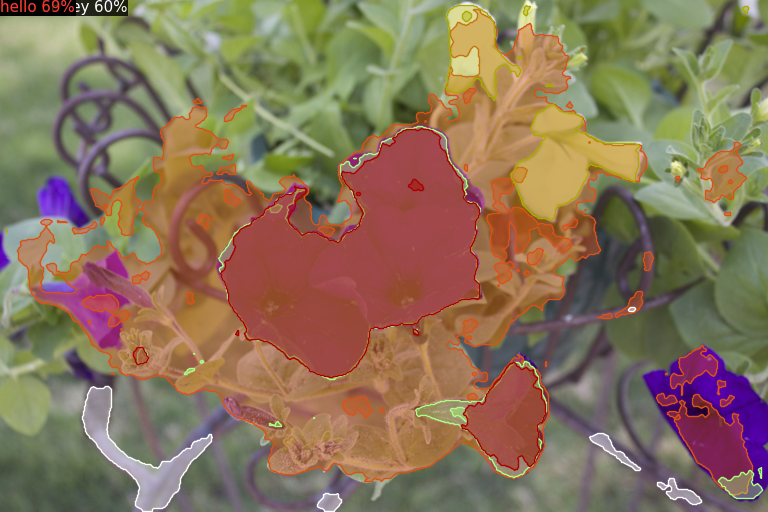

tensor([], size=(0, 512, 768))


In [11]:
im_dir = 'images/*'
im_dir = 'images/0b6d9dd51013e6a4.jpg'

confidence_threshold = 0.65 #you can adapt this to whatever you like between 0 and 1 -- the higher, the more harsh on the confidence threshold. 0.5 is reasonable

for filename in glob.glob(im_dir):
    image = Image.open(filename)
    image_model = transform(image)

    #test the image through the model
    with torch.no_grad():
        results = infer_image(model, image_model)

    #if we look for "instances" of objects, as in object detection
    obj_preds = results[0]['instances'].to('cpu')

    #convert segmentation masks into boxes
    # for mIdx in range(len(results[-1]['instances'].pred_masks)): # TODO - 100 instances, some doubled up, capped?
    #     obj_preds.pred_boxes.tensor[mIdx] = torch.Tensor(bounding_box(obj_preds.pred_masks[mIdx].numpy()))

    #threshold to remove all object detections that don't meet the confidence threshold
    mask_score = obj_preds.scores >= confidence_threshold
    print(obj_preds.scores)
    print(mask_score)

    #a function that will draw any object detections (with a confidence above 0.5) on the image
    draw_obj_dets(image_model, metadata, obj_preds)
    
    # det_boxes = obj_preds.pred_boxes[mask_score] #list of detection bounding boxes (in the transformed image coordinates (image_model))
    # det_scores = obj_preds.scores[mask_score] # list of detection confidence scores
    det_masks = obj_preds.pred_masks[mask_score] #list of detection segmentation masks
    # det_classes = obj_preds.pred_classes[mask_score] #list of detection predicted classes
    # det_similarities = obj_preds.similarities[mask_score]

    print(det_masks)
